In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
#loading the dataset
df= pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


##Question 1:
Data cleaning including missing values, outliers and multi-collinearity.

In [ ]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [ ]:
df.dropna(inplace=True)

In [ ]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


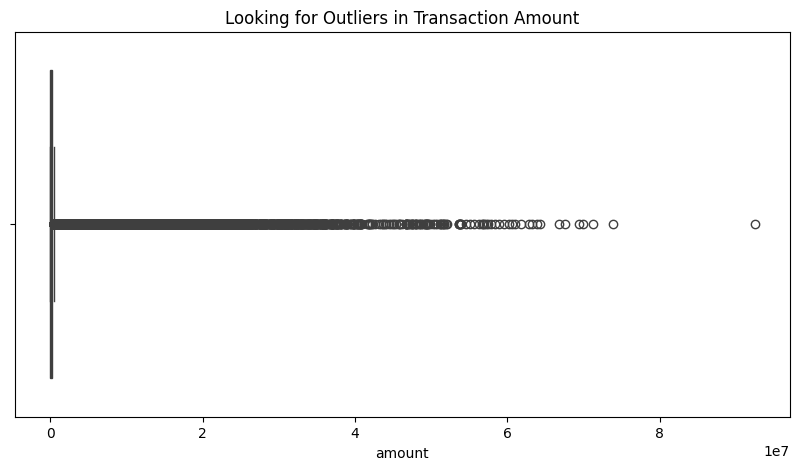

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["amount"])
plt.title("Looking for Outliers in Transaction Amount")
plt.show()

From this boxplot, we can see a skewed image with outliers in large transaction amounts. I will not remove thses outliers because in context of fraud detection, large transaction are indicators of fraudulent activities.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4464974 entries, 0 to 4464973
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 408.8+ MB


Here, I will drop column "isFlaggedFraud" because i do not want my model to be exposed to this information and also change the type to int64 so my model can understand it.

In [ ]:
df.drop(columns=[ "isFlaggedFraud"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4464974 entries, 0 to 4464973
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
dtypes: float64(6), int64(1), object(3)
memory usage: 374.7+ MB


Next, I will use variance inflation factor(VIF) to show how well a variable can be predicted from other data.

In [ ]:
numeric_df= df.select_dtypes(include=["float64", "int64"])
vif_data= pd.DataFrame()
vif_data["Feature"] = numeric_df.columns

vif_data["VIF"]= [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
print(vif_data.sort_values(by="VIF", ascending=False))

          Feature         VIF
3  newbalanceOrig  697.670738
2   oldbalanceOrg  694.719534
5  newbalanceDest   53.011953
4  oldbalanceDest   42.591873
1          amount    3.890759
0            step    1.194756
6         isFraud    1.127761


Upon checking the VIF, we can see that there is severe multicollinearity in the balance columns especially old and new balances.
For this, i will create a difference variable and drop the old columns.
I did this to preserve my model's stability

In [ ]:
df["diff_orig"]= df["newbalanceOrig"]- df["oldbalanceOrg"]
df["diff_dest"]= df["newbalanceDest"]- df["oldbalanceDest"]

#Drop the old columns
drop_cols= ["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "nameOrig", "nameDest"]
df_clean= df.drop(columns=[
    d for d in drop_cols if d in df.columns
])
print(df_clean.head())

   step      type    amount  isFraud  diff_orig  diff_dest
0     1   PAYMENT   9839.64      0.0   -9839.64        0.0
1     1   PAYMENT   1864.28      0.0   -1864.28        0.0
2     1  TRANSFER    181.00      1.0    -181.00        0.0
3     1  CASH_OUT    181.00      1.0    -181.00   -21182.0
4     1   PAYMENT  11668.14      0.0  -11668.14        0.0


In [ ]:
df_clean["type"]= df_clean["type"].astype("category").cat.codes
print(df_clean.head())

   step  type    amount  isFraud  diff_orig  diff_dest
0     1     3   9839.64      0.0   -9839.64        0.0
1     1     3   1864.28      0.0   -1864.28        0.0
2     1     4    181.00      1.0    -181.00        0.0
3     1     1    181.00      1.0    -181.00   -21182.0
4     1     3  11668.14      0.0  -11668.14        0.0


##Question 2 and 3:
I will be using RandomForestClassifier to create my model because it is a method that is most suitable for complex problems. It works by building different individual trees during training and merges their results. Then the final decision taken is gotten from the majority results across all trees.

For the next step, i will split the data so that i can test the model on data it has not seen yet to determine it's precision and efficiency.
I will be splitting it based on 80% train, 20% test because this ensures my model has enough data to use for its training.

In [ ]:
#Splitting the data into Features X and target y
X= df_clean.drop(columns="isFraud")
y= df_clean["isFraud"]

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(3571979, 5)
(3571979,)


Now, I will create my model by initializing Random Forest and training my model.

In [ ]:
model= RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Due to the masssive scale of thebdataset, training a Random Forest with 100 estimators was computationally intensive. I made sure to put the model depth and diversity over training speed to ensure high precision.

I will use my trained model to predict  fraud on my test data

In [ ]:
y_pred= model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    892287
         1.0       0.97      0.74      0.84       708

    accuracy                           1.00    892995
   macro avg       0.98      0.87      0.92    892995
weighted avg       1.00      1.00      1.00    892995



**Intepretting the results:**
Precision (0.97): My model is correct 97% of the time when it flags a transaction as fraud.
Recall (0.74): My model successfully caught 74% of all actual fraud in the dataset.

##Question 4: Demonstrate the performance of the model
The Random Forest model achieved a precision of 97% and recall of 74% on the test set. This high values shows that this model is a good one.

##Question 5: What key factors predict fraudulent customers?
The key factors that predict fraudulent data are
1. diff_orig
2. diff_dest

In [ ]:
#Get importance
importances= model.feature_importances_
feature_names= X.columns
feature_importance_df= pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

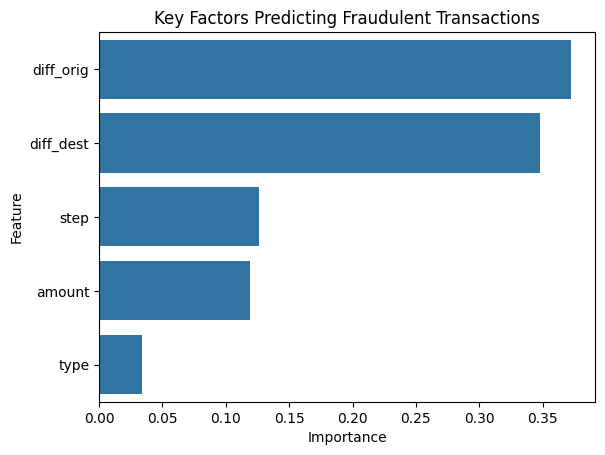

In [ ]:
plt.Figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Key Factors Predicting Fraudulent Transactions")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

##Question 6: Does this make sense?
Yes, they make perfect sense. I say so because fraudsters usually try to empty victim's account completely which creates a specific pattern in the balance. They also move money into new accounts and withdraw it immediately, which shows up in the receiver's balance changes.

##Question 7: How can the company stop this?
They can either set up alerts that flags any transaction aiming to move an account to zero or ask for extra security measures before carrying out any transaction.

##Question 8: How do we know if it worked?
1. There'll be lesser fraud
2. The model will be detecting more suspicious transactions.

In [ ]:
y_test_pred= model.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))

[[892270     17]
 [   184    524]]


##Conclusion:
This project successfully implemented a Random Forest model that can predict fraudulent transactions with a 97% precision making sure that the customers are rarely inconvenienced.

In [ ]:
joblib.dump(model, "fraud_model_prediction.pkl")
joblib.dump(X.columns, "model_features.pkl")
print("Model and Features saved successfully!")

Model and Features saved successfully!
